###### 17/10/2022
###### Author : Meriem HAFID

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

##### After initializing all the libraries that we need in our algorithm now we have to import our dataset with the help of the pandas library

In [2]:
data = pd.read_csv("trading_data.csv", header = 0) #Importing the data 

##### We start by calcuting our explicatif variable for our model, let call it "payoff"

In [3]:
data['payoff'] = data['buy/sell']*(data['answeredprice'] - data['midprice']) #adding a column of the payoff 
data.head()

,Unnamed: 0,midprice,id,buy/sell,answeredprice,deal,payoff
0,0,97.9990,4,1,98.016,0.0,0.0170
1,1,97.9988,4,-1,98.001,1.0,-0.0022
2,2,97.9951,1,-1,97.979,0.0,0.0161
3,3,97.9971,1,1,97.990,1.0,-0.0071
4,4,97.9961,1,-1,97.978,0.0,0.0181


### 1.1 Estimating $\alpha$ and $\beta$, case where we consider that all the clients have the same behavior :

To estimate $\alpha$ and $\beta$ we need to do a logistic regression using sklearnn, where LogisticRegression minimizes the log-loss which is simply the log-likelihood multiplied by -1.

Here our $\alpha$ and $\beta$ are slightly different from the sigmoid function coefficients so we multpilie by -1 to get the right intercept and coefficient for the given probability.

In [4]:
data_clean = data.dropna()
X = data_clean[['payoff']]
y = data_clean['deal']
# Standardize the data
#The mean and standard deviation are calculated for the feature and then the feature is scaled
sc = StandardScaler().fit(X)
X = sc.transform(X)
model = LogisticRegression()
mdl = model.fit(X, y)
beta = - mdl.coef_[0,0]
alpha = - mdl.intercept_[0]
print('alpha:{0:.4f}'.format(alpha), 'beta:{0:.4f}'.format(beta))

alpha:-0.3155 beta:3.3870


### 1.2 Evaluating the probability of a trade for each of the last 200 requests :

In [5]:
#extraction of the last 200 rows
data_to_be_predicted = data.iloc[-200:].drop(columns=['deal'])
#Prediction of the trade proba for the last 200 rows using the probability given in the exercice 
proba_to_trade = pd.DataFrame(np.divide(1, 1 + np.exp(alpha + beta*data_to_be_predicted['payoff']))).rename(columns={'payoff': 'proba of a trade'})
data_predicted = pd.concat([data_to_be_predicted,proba_to_trade], axis = 1)
data_predicted

,Unnamed: 0,midprice,id,buy/sell,answeredprice,payoff,proba of a trade
2000,2000,98.0025,3,1,98.001,-0.0015,0.579455
2001,2001,98.0003,2,-1,98.015,-0.0147,0.590310
2002,2002,98.0020,4,-1,97.984,0.0180,0.563281
2003,2003,97.9991,4,1,97.988,-0.0111,0.587358
2004,2004,98.0003,2,-1,98.008,-0.0077,0.584564
...,...,...,...,...,...,...,...
2195,2195,97.9943,1,-1,97.995,-0.0007,0.578795
2196,2196,97.9977,2,1,98.014,0.0163,0.564697
2197,2197,97.9999,3,1,98.009,0.0091,0.570682
2198,2198,98.0019,2,-1,98.007,-0.0051,0.582424


## 2. Clustering : 

### 2. Let classifie the data into two types of client among the 4 ID using k-means Algorithm : 
#### Impelementing the Elbow method to ensure that we are selecting the optimal number of clusters for K-means clustering

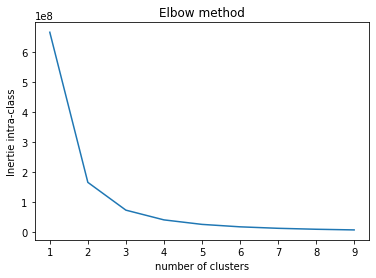

In [6]:
df = data.dropna()
tab=[]
for i in range(1,10):
    kmeans=KMeans(n_clusters=i)
    kmeans.fit(df)
    tab.append(kmeans.inertia_)
plt.plot(range(1,10),tab)
plt.title("Elbow method")
plt.xlabel("number of clusters")
plt.ylabel("Inertie intra-class")
plt.show()

#### K-means Algorithm :

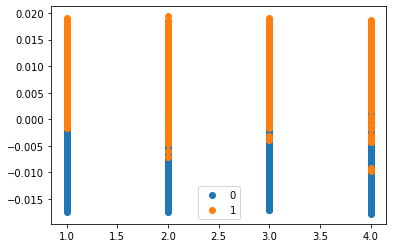

In [24]:
X_unsupervised = data.dropna()
# Standardize the data
sc = StandardScaler()
sc.fit(X_unsupervised)
X_reduced = sc.transform(X_unsupervised)
# kmeans with 2 clusters 
kmeans = KMeans(n_clusters=2, random_state=1).fit(X_reduced)
predictions = kmeans.predict(X_reduced)
unique_labels = np.unique(predictions)
for i in unique_labels:
   plt.scatter(X_unsupervised['id'].iloc[predictions == i], X_unsupervised['payoff'].iloc[predictions == i] , label = i)
plt.legend()
plt.show()

From the plot we conclude that the ID 1 and 3 have the same behaviour in trading, similar conclusion for ID 2 and 4.
The label given in this clustering do not let appear the groups by id but by behaviour, it can be seen as an appetite to trade or not.

### 3. Algorithm to evaluate the probability of a trade for each of the last 200 requests, case of two clients behave differently :


### Distinguish between Client 1 with ID 1 and 3 and Client 2 with ID 2 and 4

In [8]:
data.loc[data['id'] == 1, 'client'] = 1 
data.loc[data['id'] == 3, 'client'] = 1 
data.loc[data['id'] == 2, 'client'] = 2 
data.loc[data['id'] == 4, 'client'] = 2 

We creat a fonction to predict the probability to trade for the 200 last requests by taking on consideration that there is two clients with different behaviour as we divide our dataset into client 1 and client 2 and after on the basis of train and test split now we have to scale our feature dataset with the help of StandardScaler library and apply logistic regression on the training set, here the traning set is the 2000 first requests.

## Using a logitic regression 

In [18]:
def predict_last_requests(isClient1, data, data_to_be_predicted):    
    data = data.dropna()
    # Take only client 1 or client 2
    data_splited = data[data['client'] == (1 if isClient1 else 2) ] 
    X_train = data_splited['payoff'].values.reshape(-1,1)
    y_train = data_splited['deal']
    data_to_be_predicted_splited = data_to_be_predicted[data_to_be_predicted['client'] == (1 if isClient1 else 2)]
    X_test = data_to_be_predicted_splited['payoff'].values.reshape(-1,1)
    sc = StandardScaler()
    sc.fit(X_train)
    X_train_reduced = sc.transform(X_train)
    X_test_reduced = sc.transform(X_test)
    
    # Create and fit the model
    model = LogisticRegression()
    mdl = model.fit(X_train_reduced,y_train)
    beta = - mdl.coef_[0,0]
    alpha = - mdl.intercept_[0]
    
    #Predict
    y_predicted = model.predict(X_test_reduced)
    
    #Probability to say if the client accepted the deal
    proba_to_trade = pd.DataFrame(np.divide(1, 1 + np.exp(alpha + beta*data_to_be_predicted_splited['payoff']))).rename(columns={'payoff': 'proba of a trade'})
    data_predicted = pd.concat([data_to_be_predicted_splited,proba_to_trade], axis = 1)
    print('alpha:{0:.4f}'.format(alpha), 'beta:{0:.4f}'.format(beta))
    return data_predicted

### Evaluating the probability of a trade for each of the last 200 requests :

### Client 1 (ID 1 & 3):

In [19]:
predict_last_requests(True,data,data.iloc[-200:])

alpha:0.0385 beta:5.6612


,Unnamed: 0,midprice,id,buy/sell,answeredprice,deal,payoff,client,proba of a trade
2000,2000,98.0025,3,1,98.001,NaN,-0.0015,1.0,0.492499
2006,2006,97.9996,1,1,97.995,NaN,-0.0046,1.0,0.496886
2007,2007,98.0039,3,1,98.017,NaN,0.0131,1.0,0.471865
2009,2009,98.0002,1,-1,97.997,NaN,0.0032,1.0,0.485850
2010,2010,97.9989,1,-1,97.991,NaN,0.0079,1.0,0.479206
...,...,...,...,...,...,...,...,...,...
2188,2188,97.9901,3,-1,97.972,NaN,0.0181,1.0,0.464816
2191,2191,97.9965,3,1,97.992,NaN,-0.0045,1.0,0.496744
2192,2192,97.9992,1,-1,98.009,NaN,-0.0098,1.0,0.504245
2195,2195,97.9943,1,-1,97.995,NaN,-0.0007,1.0,0.491367


### Client 2 (ID 2 & 4):

In [20]:
predict_last_requests(False,data,data.iloc[-200:])

alpha:-0.5059 beta:2.6082


,Unnamed: 0,midprice,id,buy/sell,answeredprice,deal,payoff,client,proba of a trade
2001,2001,98.0003,2,-1,98.015,NaN,-0.0147,2.0,0.632809
2002,2002,98.0020,4,-1,97.984,NaN,0.0180,2.0,0.612777
2003,2003,97.9991,4,1,97.988,NaN,-0.0111,2.0,0.630625
2004,2004,98.0003,2,-1,98.008,NaN,-0.0077,2.0,0.628557
2005,2005,97.9993,2,1,98.003,NaN,0.0037,2.0,0.621589
...,...,...,...,...,...,...,...,...,...
2193,2193,97.9962,4,-1,98.001,NaN,-0.0048,2.0,0.626789
2194,2194,97.9970,2,-1,97.996,NaN,0.0010,2.0,0.623244
2196,2196,97.9977,2,1,98.014,NaN,0.0163,2.0,0.613828
2198,2198,98.0019,2,-1,98.007,NaN,-0.0051,2.0,0.626972


## Using Stochastic gradient descent 

In [21]:
def predict_last_requests2(isClient1, data, data_to_be_predicted):    
    data = data.dropna()
    # Take only client 1 or client 2
    data_splited = data[data['client'] == (1 if isClient1 else 2) ] 
    X_train = data_splited['payoff'].values.reshape(-1,1)
    y_train = data_splited['deal']
    data_to_be_predicted_splited = data_to_be_predicted[data_to_be_predicted['client'] == (1 if isClient1 else 2)]
    X_test = data_to_be_predicted_splited['payoff'].values.reshape(-1,1)
    sc = StandardScaler()
    sc.fit(X_train)
    X_train_reduced = sc.transform(X_train)
    X_test_reduced = sc.transform(X_test)
    
    # Create and fit the model with an SGD 
    model2 = SGDClassifier(loss='log')
    mdl2 = model2.fit(X_train_reduced,y_train)
    beta = - mdl2.coef_[0,0]
    alpha = - mdl2.intercept_[0]
    
    #Predict
    y_predicted = model2.predict(X_test_reduced)
    
    #Probability to say if the client accepted the deal
    proba_to_trade = pd.DataFrame(np.divide(1, 1 + np.exp(alpha + beta*data_to_be_predicted_splited['payoff']))).rename(columns={'payoff': 'proba of a trade'})
    data_predicted = pd.concat([data_to_be_predicted_splited,proba_to_trade], axis = 1)
    print('alpha:{0:.4f}'.format(alpha), 'beta:{0:.4f}'.format(beta))
    return data_predicted

### Client 1 (ID 1 & 3):

In [22]:
predict_last_requests2(True,data,data.iloc[-200:])

alpha:0.0381 beta:7.4365


,Unnamed: 0,midprice,id,buy/sell,answeredprice,deal,payoff,client,proba of a trade
2000,2000,98.0025,3,1,98.001,NaN,-0.0015,1.0,0.493273
2006,2006,97.9996,1,1,97.995,NaN,-0.0046,1.0,0.499036
2007,2007,98.0039,3,1,98.017,NaN,0.0131,1.0,0.466181
2009,2009,98.0002,1,-1,97.997,NaN,0.0032,1.0,0.484539
2010,2010,97.9989,1,-1,97.991,NaN,0.0079,1.0,0.475815
...,...,...,...,...,...,...,...,...,...
2188,2188,97.9901,3,-1,97.972,NaN,0.0181,1.0,0.456940
2191,2191,97.9965,3,1,97.992,NaN,-0.0045,1.0,0.498850
2192,2192,97.9992,1,-1,98.009,NaN,-0.0098,1.0,0.508702
2195,2195,97.9943,1,-1,97.995,NaN,-0.0007,1.0,0.491786


### Client 2 (ID 2 & 4):

In [23]:
predict_last_requests2(False,data,data.iloc[-200:])

alpha:-0.9907 beta:2.5625


,Unnamed: 0,midprice,id,buy/sell,answeredprice,deal,payoff,client,proba of a trade
2001,2001,98.0003,2,-1,98.015,NaN,-0.0147,2.0,0.736604
2002,2002,98.0020,4,-1,97.984,NaN,0.0180,2.0,0.720027
2003,2003,97.9991,4,1,97.988,NaN,-0.0111,2.0,0.734810
2004,2004,98.0003,2,-1,98.008,NaN,-0.0077,2.0,0.733109
2005,2005,97.9993,2,1,98.003,NaN,0.0037,2.0,0.727354
...,...,...,...,...,...,...,...,...,...
2193,2193,97.9962,4,-1,98.001,NaN,-0.0048,2.0,0.731652
2194,2194,97.9970,2,-1,97.996,NaN,0.0010,2.0,0.728724
2196,2196,97.9977,2,1,98.014,NaN,0.0163,2.0,0.720905
2198,2198,98.0019,2,-1,98.007,NaN,-0.0051,2.0,0.731803
